In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [3]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.percentile(ecg_rr[ecg_rr>0],80)
    s = np.percentile(ecg_rr[ecg_rr>0],20)
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         index = ppg_rr>0
#         ppg_qual = ppg_qual[index]
#         ppg_rr = ppg_rr[index]
        index = np.isnan(ppg_rr)
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<60:
            continue
        ppg_qual[index] = -1
        ppg_rr[index] = np.nanmean(ppg_rr)
        y.append(ecg_rr.reshape(1,60,1))
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(1,60,9)
        tmp[np.isnan(tmp)] = 0
        tmp[tmp==0] = 0
        X.append(tmp)
        means.append(m)
        stds.append(s)
        ecg.append(ppg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
#         for j in np.linspace(0,.9,20):
#             index = ppg_qual>j
#             ppg_qual = ppg_qual[index]
#             ppg_rr = ppg_rr[index]
#             if len(ppg_rr)<10:
#                 continue
#             f = list(get_time_domain_features(ppg_rr).values())
#             f1 = list(get_time_domain_features(ecg_rr).values())
#             q = [np.percentile(ppg_qual,20),np.median(ppg_qual),len(ppg_rr)/60]
#             features.append(np.array(f1+f+q))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
all_X = []
for user in unique_users:
    data_user = data_all[data_all.user.isin([user])]
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        continue
    df_col = Parallel(n_jobs=20,verbose=1)(delayed(get_data)(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60)
#     df_col = [get_data(group_name, df_group) for group_name, df_group
#                                            in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = Parallel(n_jobs=20,verbose=1)(delayed(get_data1)(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20)    
    all_X.extend(df_col)
    print(user)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 202 out of 241 | elapsed:    4.6s remaining:    0.9s
[Parallel(n_jobs=20)]: Done 241 out of 241 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 182 out of 182 | elapsed:    0.4s finished


44514a20-82cf-45ee-8fae-828f2ec4f035


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 15960 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 19305 out of 19305 | elapsed:   16.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   8 out of  23 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  23 out of  23 | elapsed:    0.1s finished


3133920d-164a-48e6-8d9e-79e919c45d43


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 11645 out of 11645 | elapsed:   11.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1104 out of 1104 | elapsed:    1.1s finished


72cc0041-a4a9-4194-b1e3-bf8e829c5eee


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 3224 out of 3224 | elapsed:    3.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    0.0s finished


c5e2565c-3956-43f4-9b83-4e9a0bd1a0d0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2608 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5408 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 9008 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 13408 tasks      | elapsed:   12.6s
[Parallel(n_jobs=20)]: Done 18608 tasks      | elapsed:   17.5s
[Parallel(n_jobs=20)]: Done 24608 tasks      | elapsed:   23.1s
[Parallel(n_jobs=20)]: Done 31408 tasks      | elapsed:   29.5s
[Parallel(n_jobs=20)]: Done 39008 tasks      | elapsed:   36.6s
[Parallel(n_jobs=20)]: Done 40766 out of 40766 | elapsed:   38.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jo

c1b4671b-623b-42b9-a216-42d57ba8cc61
d058f876-d943-4cb0-8e07-540dabb1d7f6


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 7932 out of 7932 | elapsed:    7.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1459 out of 1

099b45df-6432-47d2-8332-a8a870ec79de


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.6s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 20658 out of 20658 | elapsed:   19.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  74 out of 113 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 113 out of 113 | elapsed:    0.2s finished


f2bdd151-3fb8-497a-8380-a2b65dc01c2c


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 4433 out of 4433 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 202 out of 202 | elapsed:    0.3s finished


c1895fe4-14ca-4433-95c1-3430fc4c8c35


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 12499 out of 12499 | elapsed:   12.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


e79e7e79-93ea-49bf-85ce-c174492c8a14


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2892 out of 2892 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    0.0s finished


2c68bc6e-7756-4e00-9a7b-face9ba98cec


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 20073 out of 20073 | elapsed:   19.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1860 out of 1860 | elapsed:    1.4s finished


b71b2071-6330-434d-a2ab-8e929e9b96a9


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 6905 out of 6905 | elapsed:    5.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 924 out of 924 | elapsed:    0.6s finished


37ab3c6b-092a-494d-a9b8-9f961e9d008a


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1049 out of 1049 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


eccf2bea-169d-4dce-a9b9-93b4e0c7be83


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.9s
[Parallel(n_jobs=20)]: Done 21883 out of 21883 | elapsed:   20.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 647 out of 647 | elapsed:    0.6s finished


0dbd4034-a57f-4056-a8a1-e0d6ba8fdd93


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 6051 out of 6051 | elapsed:    5.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  61 out of  61 | elapsed:    0.2s finished


59ae4c3e-e2d1-4cba-b314-92656fe65360


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2650 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 2807 out of 2807 | elapsed:    3.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    0.0s finished


a8c3335f-fd55-40d0-b6e8-08423e67ad22


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.6s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.5s
[Parallel(n_jobs=20)]: Done 21844 out of 21844 | elapsed:   20.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1660 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 1826 out of 1826 | elapsed:    1.7s finished


8008f00d-2549-46e4-ab1f-01542c1076e2


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 616 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.7s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.4s
[Parallel(n_jobs=20)]: Done 20161 out of 20161 | elapsed:   14.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1059 out of 1059 | elapsed:    1.0s finished


4ddc3405-d256-4f66-95df-2b13bf69a616


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 7084 out of 7084 | elapsed:    7.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


8d3b24b0-a89e-4ff2-aee2-8f7f67e2798c


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2250 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 2313 out of 2313 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 321 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 417 out of 417 | elapsed:    0.8s finished


460a483c-21fc-4ef6-a44a-740d43b81ed4


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 14084 out of 14084 | elapsed:   10.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 593 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 744 out of 744 | elapsed:    0.9s finished


b0f051e0-69ef-4153-9a1e-22ed921d76c3


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 16744 out of 16744 | elapsed:   16.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 276 out of 315 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 315 out of 315 | elapsed:    0.5s finished


0b4bce96-dccb-434b-b4ca-63c7fcd3a7fa


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1343 out of 1343 | elapsed:    1.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


bc40ffe4-1ec1-4add-bd8b-beb10e727783


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.0s
[Parallel(n_jobs=20)]: Done 20098 out of 20098 | elapsed:   19.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 6510 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 6991 out of 6991 | elapsed:    2.4s finished


8d96c9a4-a13b-4729-adf3-969e84b9a6d2


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1114 out of 1114 | elapsed:    1.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 142 out of 142 | elapsed:    0.3s finished


bba69ab9-3b12-45c1-997e-f64909174649


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.4s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.3s
[Parallel(n_jobs=20)]: Done 20699 out of 20699 | elapsed:   14.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.1s finished


522a66a7-1502-46fe-bce4-9e022c52219f


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 13891 out of 13891 | elapsed:   13.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 2260 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 2404 out of 2404 | elapsed:    1.7s finished


98fca87c-9940-4666-9893-9f8ae2418cb8


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.2s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 19332 out of 19332 | elapsed:   13.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 616 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 4662 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 4938 out of 4938 | elapsed:    2.2s finished


87877961-b2f8-4256-806b-973fbd798920


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=20)]: Done 19908 out of 19908 | elapsed:   19.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 5340 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 5510 out of 5510 | elapsed:    2.0s finished


bde40f50-8e35-4707-8260-b69f07773c4d


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   12.4s
[Parallel(n_jobs=20)]: Done 19679 out of 19679 | elapsed:   14.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    0.1s finished


81d3b376-3549-4639-aad5-35670e772492


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.0s
[Parallel(n_jobs=20)]: Done 20515 out of 20515 | elapsed:   19.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1450 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1639 out of 1639 | elapsed:    1.8s finished


5f3f7553-6d2f-4c08-adb9-dbc3e88ba0aa


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.8s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 19312 out of 19312 | elapsed:   18.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 933 out of 933 | elapsed:    0.6s finished


00c08d2f-3b9c-48e9-9633-5a341892cc4b


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 9347 out of 9347 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1888 out of 1888 | elapsed:    0.8s finished


ba115c26-1c87-418c-9f6b-2816cd6673ca


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 16264 out of 16264 | elapsed:   15.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 4400 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 4754 out of 4754 | elapsed:    2.0s finished


7846909f-c4a5-4d49-b11d-d1b1ca2c7309


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.0s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=20)]: Done 19600 out of 19600 | elapsed:   18.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1660 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 1812 out of 1812 | elapsed:    1.6s finished


d3cf5812-85fd-4328-9b2a-1b3b6b2cd0b0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.0s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.9s
[Parallel(n_jobs=20)]: Done 21232 out of 21232 | elapsed:   20.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 3208 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 3448 out of 3487 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 3487 out of 3487 | elapsed:    1

2d8b5a8c-e990-4442-abf6-578e96d2f5eb


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 10200 tasks      | elapsed:    7.5s
[Parallel(n_jobs=20)]: Done 15777 out of 15777 | elapsed:   11.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1660 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1762 out of 1801 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 1801 out of 1801 | elapsed:    1.6s finished


263b1782-923d-4bb3-b52d-4c1926e81f1f


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.2s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.3s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.2s
[Parallel(n_jobs=20)]: Done 19199 out of 19199 | elapsed:   18.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 2690 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 2799 out of 2799 | elapsed:    1.7s finished


34e42cf6-7c34-417c-a003-874e3b6151e7


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 4082 out of 4082 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 166 out of 166 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


7ab70ff6-9e38-4e6f-8704-b5b4c5da730e


[Parallel(n_jobs=20)]: Done 102 out of 141 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 141 out of 141 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


23584088-0cf3-42ec-8088-dac7d51ab037


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.8s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.7s
[Parallel(n_jobs=20)]: Done 19948 out of 19948 | elapsed:   19.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 593 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 746 out of 746 | elapsed:    0.8s finished


cd7235b7-56ac-49a9-a0a7-b309e0f3507c


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 1309 out of 1309 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   0 out of   0 | elapsed:    0.0s finished


2d8278ae-4620-4106-9061-0d00625bb85d


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 15741 out of 15741 | elapsed:   15.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1392 out of 1392 | elapsed:    1.1s finished


780e89b3-f6bf-4181-9f2c-7db941735c87


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 20240 out of 20240 | elapsed:   19.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    0.1s finished


7b63e06f-4931-41e2-aa62-1eb51c5e250b


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 20120 out of 20120 | elapsed:   19.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1450 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 1627 out of 1627 | elapsed:    1.8s finished


e099e913-4796-4408-af63-1d35c84f29fd


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 10053 out of 10053 | elapsed:    9.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1923 out of 1923 | elapsed:    1.0s finished


903c1dae-a771-405f-a021-6f175724adc4


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.0s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.9s
[Parallel(n_jobs=20)]: Done 20280 out of 20319 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 20319 out of 20319 | elapsed:   19.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 4548 out of 4548 | elapsed:    1.7s finished


892e71e0-a5a4-4315-89a4-fa5518d78591


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 19480 out of 19480 | elapsed:   18.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 7030 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 7071 out of 7071 | elapsed:    2.1s finished


fdddb3bd-bb88-458f-bcc8-e50bb3f87742


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=20)]: Done 23117 out of 23117 | elapsed:   21.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 3200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 3480 out of 3519 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 3519 out of 3519 | elapsed:    1

02543bbf-84c2-4076-8547-c8a5f451ea02


In [4]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for a in all_X:
    if len(a[0])==0:
        continue
    X.extend(a[0])
    y.extend(a[1])
    ecg.extend(a[2])
    means.extend(a[3])
    stds.extend(a[4])
    quals.extend(a[5])

In [5]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [6]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [7]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [8]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([0,1,2,3,4])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_test.shape,y_val.shape,means_val.shape,stds_val.shape)

Using TensorFlow backend.


(31586, 60, 5) (19448, 60) (7897, 60) (7897, 1) (7897, 1)


In [21]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return tfp.stats.percentile(x,80, axis=1)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return tfp.stats.percentile(x,20, axis=1)

timesteps = 60
input_dim = 5
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

# encoded = TimeDistributed(Dense(,activation='relu'))(mer)
encoded = Flatten()(mer)
encoded = Dense(10,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "logcosh"
}
lossWeights = {"mean": 1, "sequence": 1,"std":1}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 5)        0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 60, 120)      23760       input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 60, 1)        121         bidirectional_3[0][0]            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 60)           0           dense_4[0][0]                    
____________________________________________________________________________________________

In [10]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=1000,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 31586 samples, validate on 7897 samples
Epoch 1/300
31586/31586 [==============================] - 11s 354us/step - loss: 2099.1586 - sequence_loss: 660.2451 - mean_loss: 736.1443 - std_loss: 702.3552 - val_loss: 2043.9599 - val_sequence_loss: 645.5044 - val_mean_loss: 698.5642 - val_std_loss: 699.7768

Epoch 00001: val_loss improved from inf to 2043.95994, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
31586/31586 [==============================] - 10s 315us/step - loss: 1986.0778 - sequence_loss: 627.6135 - mean_loss: 655.2499 - std_loss: 702.3322 - val_loss: 1897.9610 - val_sequence_loss: 601.7506 - val_mean_loss: 596.3224 - val_std_loss: 699.7409

Epoch 00002: val_loss improved from 2043.95994 to 1897.96103, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
31586/31586 [==============================] - 10s 316us/step - loss: 1779.5162 - sequence_loss: 563.2075 - mean_loss: 512.6836 - std_loss: 701.8893 - val_loss: 1626.0434 - val_sequence_loss: 514.2585 - val_mea

31586/31586 [==============================] - 10s 316us/step - loss: 397.3940 - sequence_loss: 164.0424 - mean_loss: 124.0201 - std_loss: 109.2221 - val_loss: 391.9071 - val_sequence_loss: 161.7843 - val_mean_loss: 122.5404 - val_std_loss: 107.5125

Epoch 00023: val_loss improved from 392.99520 to 391.90706, saving model to ../models/base_LSTM.hdf5
Epoch 24/300
31586/31586 [==============================] - 10s 313us/step - loss: 396.3314 - sequence_loss: 163.3426 - mean_loss: 123.9559 - std_loss: 109.1418 - val_loss: 391.0116 - val_sequence_loss: 161.1828 - val_mean_loss: 122.3550 - val_std_loss: 107.4081

Epoch 00024: val_loss improved from 391.90706 to 391.01157, saving model to ../models/base_LSTM.hdf5
Epoch 25/300
31586/31586 [==============================] - 10s 317us/step - loss: 395.2941 - sequence_loss: 162.5704 - mean_loss: 123.6486 - std_loss: 108.8768 - val_loss: 389.9843 - val_sequence_loss: 160.5117 - val_mean_loss: 122.1729 - val_std_loss: 107.2336

Epoch 00025: val_lo

31586/31586 [==============================] - 10s 313us/step - loss: 383.2777 - sequence_loss: 151.8281 - mean_loss: 123.1165 - std_loss: 108.3388 - val_loss: 378.7874 - val_sequence_loss: 150.5009 - val_mean_loss: 121.9168 - val_std_loss: 106.2997

Epoch 00046: val_loss did not improve from 378.06129
Epoch 47/300
31586/31586 [==============================] - 10s 319us/step - loss: 383.5927 - sequence_loss: 152.0487 - mean_loss: 122.9957 - std_loss: 108.3226 - val_loss: 378.5962 - val_sequence_loss: 150.8164 - val_mean_loss: 121.1458 - val_std_loss: 106.5820

Epoch 00047: val_loss did not improve from 378.06129
Epoch 48/300
31586/31586 [==============================] - 10s 314us/step - loss: 383.0946 - sequence_loss: 152.3551 - mean_loss: 122.7967 - std_loss: 108.1519 - val_loss: 377.8181 - val_sequence_loss: 150.6419 - val_mean_loss: 121.1267 - val_std_loss: 105.9865

Epoch 00048: val_loss improved from 378.06129 to 377.81811, saving model to ../models/base_LSTM.hdf5
Epoch 49/300
3

31586/31586 [==============================] - 10s 315us/step - loss: 379.5177 - sequence_loss: 150.6118 - mean_loss: 121.7107 - std_loss: 107.0911 - val_loss: 374.0702 - val_sequence_loss: 148.5511 - val_mean_loss: 120.1389 - val_std_loss: 105.3089

Epoch 00070: val_loss improved from 374.66307 to 374.07020, saving model to ../models/base_LSTM.hdf5
Epoch 71/300
31586/31586 [==============================] - 10s 316us/step - loss: 378.8950 - sequence_loss: 150.1062 - mean_loss: 121.7714 - std_loss: 107.1011 - val_loss: 374.1088 - val_sequence_loss: 148.7625 - val_mean_loss: 120.3797 - val_std_loss: 104.8896

Epoch 00071: val_loss did not improve from 374.07020
Epoch 72/300
31586/31586 [==============================] - 10s 319us/step - loss: 378.8983 - sequence_loss: 150.0910 - mean_loss: 121.7329 - std_loss: 107.1212 - val_loss: 374.1258 - val_sequence_loss: 149.2093 - val_mean_loss: 120.1468 - val_std_loss: 104.6835

Epoch 00072: val_loss did not improve from 374.07020
Epoch 73/300
3


Epoch 00094: val_loss did not improve from 371.77859
Epoch 95/300
31586/31586 [==============================] - 10s 314us/step - loss: 377.5176 - sequence_loss: 150.8885 - mean_loss: 120.7059 - std_loss: 106.0377 - val_loss: 372.3278 - val_sequence_loss: 149.7311 - val_mean_loss: 118.9301 - val_std_loss: 103.5928

Epoch 00095: val_loss did not improve from 371.77859
Epoch 96/300
31586/31586 [==============================] - 10s 317us/step - loss: 376.8362 - sequence_loss: 150.5751 - mean_loss: 120.4473 - std_loss: 105.7596 - val_loss: 372.9616 - val_sequence_loss: 149.9392 - val_mean_loss: 119.3428 - val_std_loss: 103.6035

Epoch 00096: val_loss did not improve from 371.77859
Epoch 97/300
31586/31586 [==============================] - 10s 315us/step - loss: 377.4645 - sequence_loss: 151.2922 - mean_loss: 120.4812 - std_loss: 105.8396 - val_loss: 374.0438 - val_sequence_loss: 151.2446 - val_mean_loss: 119.4103 - val_std_loss: 103.3022

Epoch 00097: val_loss did not improve from 371.7

31586/31586 [==============================] - 10s 310us/step - loss: 375.5139 - sequence_loss: 150.2806 - mean_loss: 119.8980 - std_loss: 105.2792 - val_loss: 370.5317 - val_sequence_loss: 148.4205 - val_mean_loss: 118.3108 - val_std_loss: 103.7364

Epoch 00120: val_loss did not improve from 370.45428
Epoch 121/300
31586/31586 [==============================] - 10s 311us/step - loss: 374.7336 - sequence_loss: 149.8210 - mean_loss: 119.6681 - std_loss: 105.0893 - val_loss: 370.7132 - val_sequence_loss: 148.1738 - val_mean_loss: 118.4212 - val_std_loss: 104.0485

Epoch 00121: val_loss did not improve from 370.45428
Epoch 122/300
31586/31586 [==============================] - 10s 314us/step - loss: 374.7560 - sequence_loss: 149.6868 - mean_loss: 119.9455 - std_loss: 105.2992 - val_loss: 369.9059 - val_sequence_loss: 147.9107 - val_mean_loss: 118.3527 - val_std_loss: 103.5748

Epoch 00122: val_loss improved from 370.45428 to 369.90593, saving model to ../models/base_LSTM.hdf5
Epoch 123/30

31586/31586 [==============================] - 10s 315us/step - loss: 374.1317 - sequence_loss: 149.9023 - mean_loss: 119.3689 - std_loss: 104.8041 - val_loss: 370.4432 - val_sequence_loss: 149.4708 - val_mean_loss: 118.1723 - val_std_loss: 102.7242

Epoch 00145: val_loss did not improve from 368.87473
Epoch 146/300
31586/31586 [==============================] - 10s 315us/step - loss: 373.8441 - sequence_loss: 149.7228 - mean_loss: 119.3660 - std_loss: 104.6818 - val_loss: 369.0122 - val_sequence_loss: 147.9644 - val_mean_loss: 117.9236 - val_std_loss: 103.0531

Epoch 00146: val_loss did not improve from 368.87473
Epoch 147/300
31586/31586 [==============================] - 10s 312us/step - loss: 373.5528 - sequence_loss: 149.4725 - mean_loss: 119.3123 - std_loss: 104.6473 - val_loss: 369.2034 - val_sequence_loss: 147.9661 - val_mean_loss: 117.7937 - val_std_loss: 103.3780

Epoch 00147: val_loss did not improve from 368.87473
Epoch 148/300
31586/31586 [==============================] -


Epoch 00170: val_loss did not improve from 368.37322
Epoch 171/300
31586/31586 [==============================] - 10s 314us/step - loss: 373.7009 - sequence_loss: 150.2894 - mean_loss: 118.9792 - std_loss: 104.3408 - val_loss: 369.0456 - val_sequence_loss: 149.2037 - val_mean_loss: 117.5598 - val_std_loss: 102.2095

Epoch 00171: val_loss did not improve from 368.37322
Epoch 172/300
31586/31586 [==============================] - 10s 315us/step - loss: 373.2090 - sequence_loss: 150.1226 - mean_loss: 118.8904 - std_loss: 104.1807 - val_loss: 368.3021 - val_sequence_loss: 148.2188 - val_mean_loss: 117.3188 - val_std_loss: 102.7027

Epoch 00172: val_loss improved from 368.37322 to 368.30205, saving model to ../models/base_LSTM.hdf5
Epoch 173/300
31586/31586 [==============================] - 10s 315us/step - loss: 372.6279 - sequence_loss: 149.5070 - mean_loss: 118.8489 - std_loss: 104.1989 - val_loss: 371.9641 - val_sequence_loss: 152.0114 - val_mean_loss: 117.7984 - val_std_loss: 102.075

31586/31586 [==============================] - 10s 313us/step - loss: 372.8326 - sequence_loss: 150.0511 - mean_loss: 118.7709 - std_loss: 103.9710 - val_loss: 374.1338 - val_sequence_loss: 149.7430 - val_mean_loss: 118.8887 - val_std_loss: 105.4514

Epoch 00196: val_loss did not improve from 367.81372
Epoch 197/300
31586/31586 [==============================] - 10s 316us/step - loss: 372.9097 - sequence_loss: 150.5354 - mean_loss: 118.3721 - std_loss: 103.7719 - val_loss: 368.1472 - val_sequence_loss: 148.9601 - val_mean_loss: 117.1754 - val_std_loss: 101.9378

Epoch 00197: val_loss did not improve from 367.81372
Epoch 198/300
31586/31586 [==============================] - 10s 319us/step - loss: 373.6173 - sequence_loss: 150.7938 - mean_loss: 118.6851 - std_loss: 103.9433 - val_loss: 369.1448 - val_sequence_loss: 150.3723 - val_mean_loss: 116.9804 - val_std_loss: 101.7192

Epoch 00198: val_loss did not improve from 367.81372
Epoch 199/300
31586/31586 [==============================] -

31586/31586 [==============================] - 10s 315us/step - loss: 372.8387 - sequence_loss: 150.8802 - mean_loss: 118.4184 - std_loss: 103.6710 - val_loss: 371.1148 - val_sequence_loss: 148.6540 - val_mean_loss: 118.2331 - val_std_loss: 104.1754

Epoch 00221: val_loss did not improve from 367.05525
Epoch 222/300
31586/31586 [==============================] - 10s 315us/step - loss: 373.3775 - sequence_loss: 151.3368 - mean_loss: 118.4263 - std_loss: 103.6796 - val_loss: 367.7691 - val_sequence_loss: 149.3299 - val_mean_loss: 116.5835 - val_std_loss: 101.7953

Epoch 00222: val_loss did not improve from 367.05525
Epoch 223/300
31586/31586 [==============================] - 10s 312us/step - loss: 372.2765 - sequence_loss: 150.4787 - mean_loss: 118.2933 - std_loss: 103.5476 - val_loss: 367.2299 - val_sequence_loss: 149.0216 - val_mean_loss: 116.5657 - val_std_loss: 101.5795

Epoch 00223: val_loss did not improve from 367.05525
Epoch 224/300
31586/31586 [==============================] -


Epoch 00246: val_loss did not improve from 366.73598
Epoch 247/300
31586/31586 [==============================] - 10s 313us/step - loss: 371.7722 - sequence_loss: 150.7246 - mean_loss: 117.8298 - std_loss: 103.0228 - val_loss: 367.1343 - val_sequence_loss: 148.0966 - val_mean_loss: 117.0384 - val_std_loss: 101.9351

Epoch 00247: val_loss did not improve from 366.73598
Epoch 248/300
31586/31586 [==============================] - 10s 313us/step - loss: 371.3996 - sequence_loss: 149.6159 - mean_loss: 118.2889 - std_loss: 103.5072 - val_loss: 366.9415 - val_sequence_loss: 147.8898 - val_mean_loss: 117.0296 - val_std_loss: 101.9533

Epoch 00248: val_loss did not improve from 366.73598
Epoch 249/300
31586/31586 [==============================] - 10s 312us/step - loss: 372.7311 - sequence_loss: 150.7608 - mean_loss: 118.4191 - std_loss: 103.5956 - val_loss: 371.5771 - val_sequence_loss: 148.9524 - val_mean_loss: 118.2759 - val_std_loss: 104.3016

Epoch 00249: val_loss did not improve from 36

In [12]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

NameError: name 'tfp' is not defined

In [13]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [14]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((19448, 60), (19448,), (19448,))

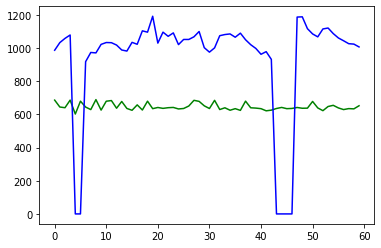

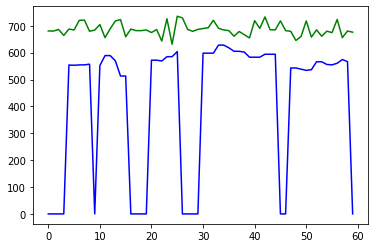

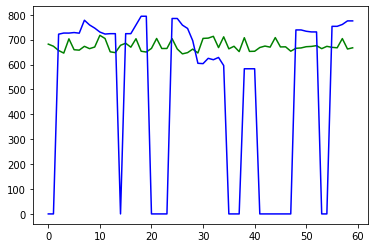

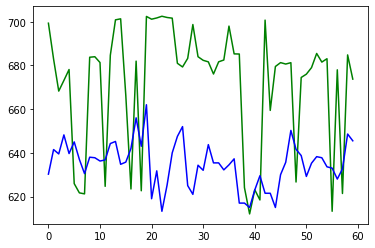

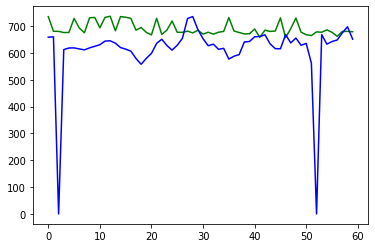

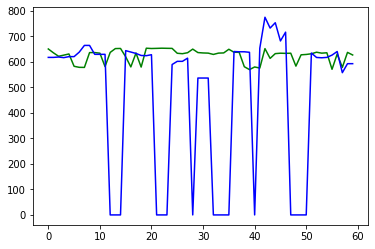

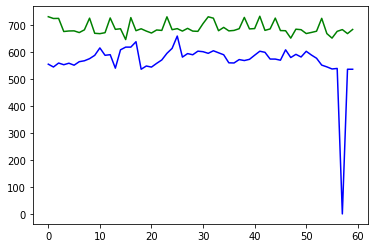

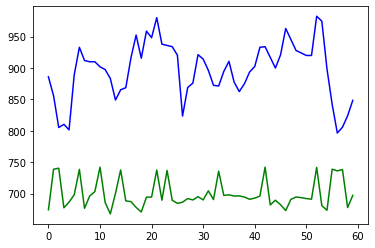

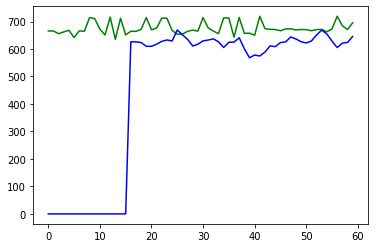

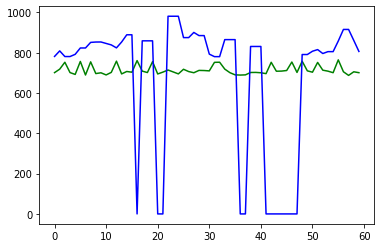

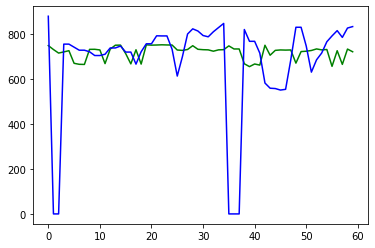

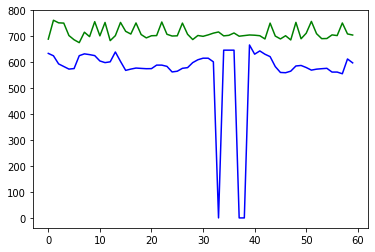

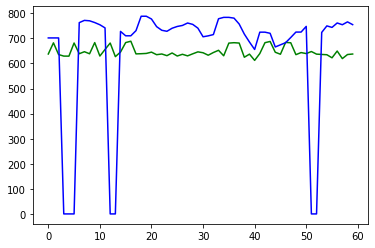

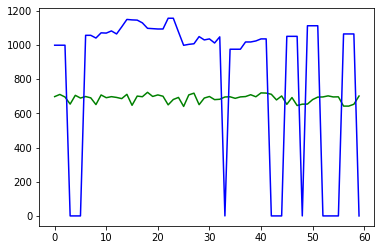

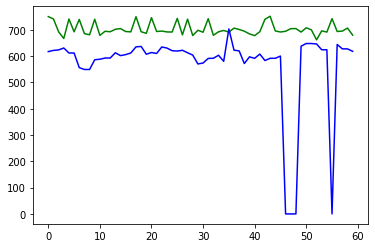

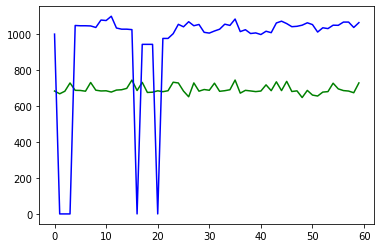

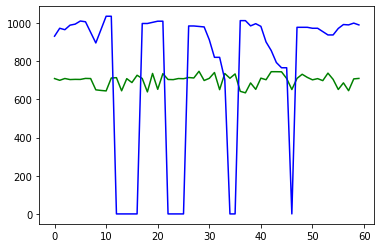

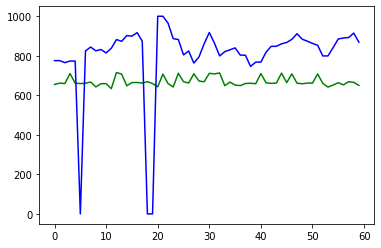

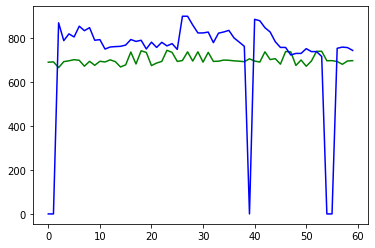

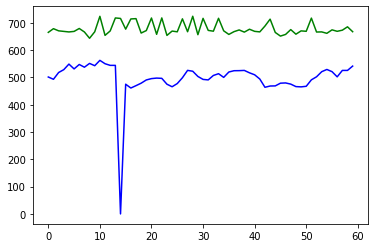

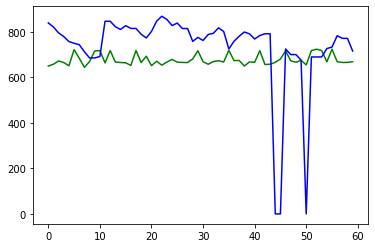

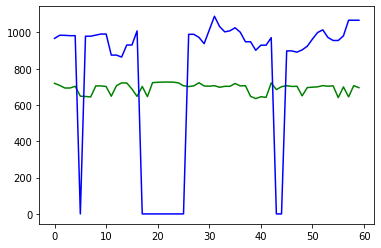

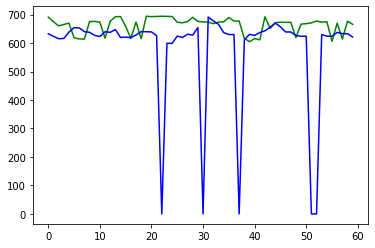

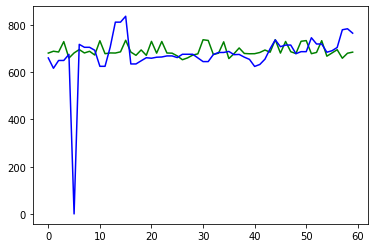

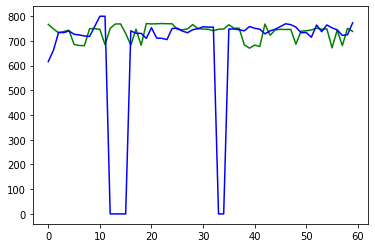

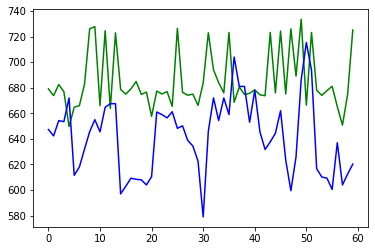

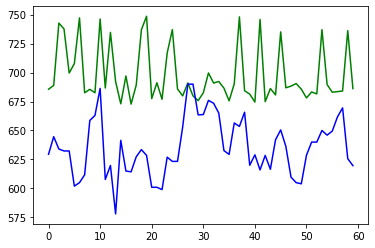

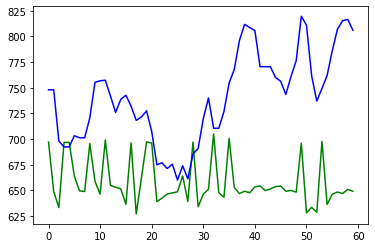

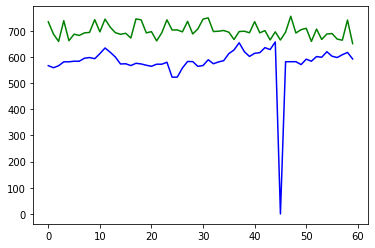

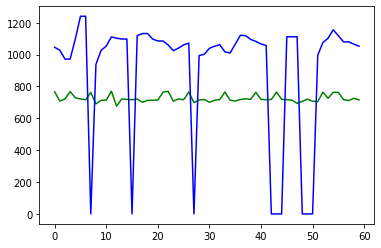

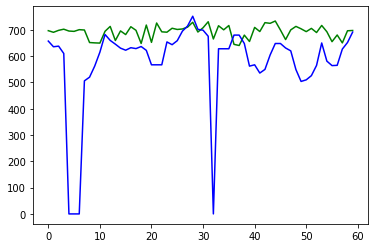

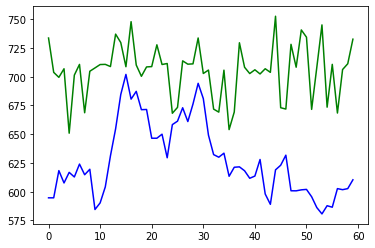

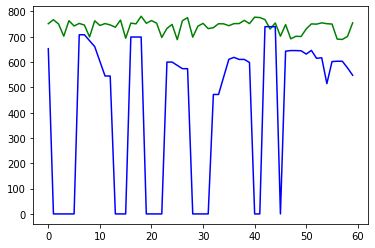

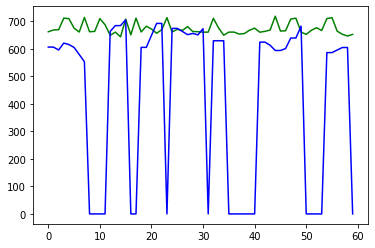

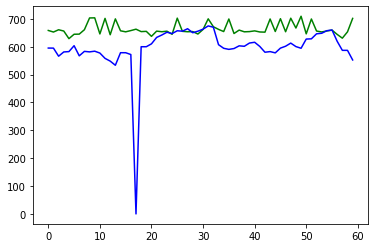

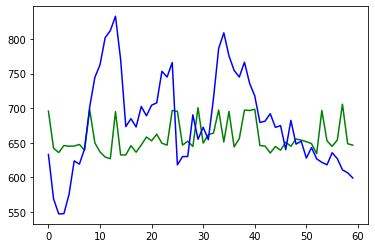

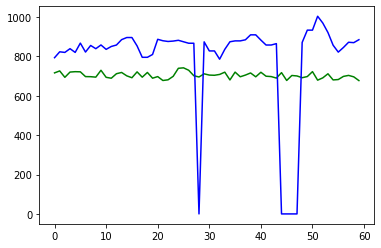

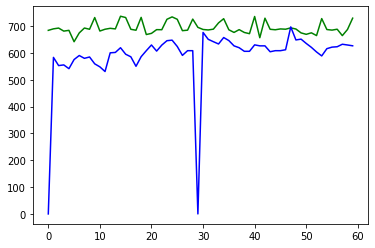

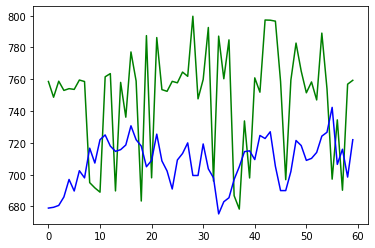

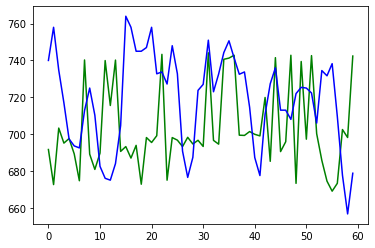

In [15]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[::-1][200:240]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
    plt.plot(y_test[i],'b')
#     plt.plot(ecg_test[i],'r')
    plt.show()

In [16]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [17]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]


(array([352994., 140439.,  82573.,  67146.,  60227.,  54118.,  49076.,
         49116.,  51921., 115700.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

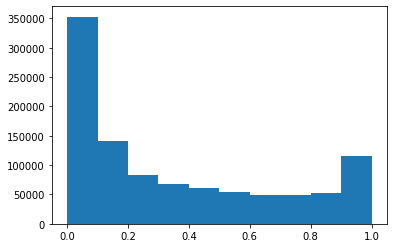

In [18]:
plt.hist(X[:,0])

(209388, 4) 0.0
(143606, 4) 0.05
(84574, 4) 0.1
(55865, 4) 0.15000000000000002
(44198, 4) 0.2
(37905, 4) 0.25
(35041, 4) 0.30000000000000004
(32105, 4) 0.35000000000000003
(30972, 4) 0.4
(29255, 4) 0.45
(27593, 4) 0.5
(26525, 4) 0.55
(24657, 4) 0.6000000000000001
(24740, 4) 0.65
(24511, 4) 0.7000000000000001
(24958, 4) 0.75
(26059, 4) 0.8
(26554, 4) 0.8500000000000001
(32128, 4) 0.9
(60044, 4) 0.9500000000000001
20 20


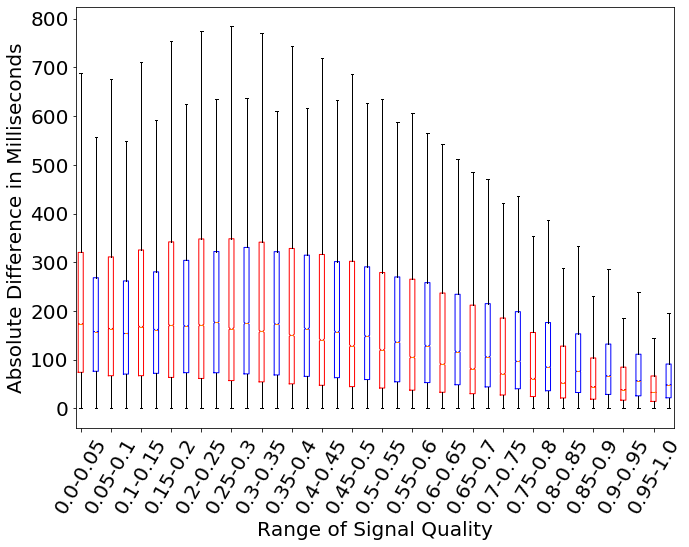

In [19]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability